# NLP EN DIÁLOGOS DE "THE SIMPSONS"

### Proyecto TEXTO para la asignatura de Análisis de Datos No Estructurados

#### Laura Gutiérrez y Natalia Mirón
#### Mayo 2022
<hr>

In [1]:
# Librerías a cargar
import numpy as np
import re  # Para preprocesamiento
import pandas as pd  # Para manipulación de datos
from time import time  # Para medir la duración de las operaciones
from collections import defaultdict  # Para la frecuencia de las palabras

import spacy  # Para preprocesamiento
from datetime import datetime

from nltk.tokenize import TweetTokenizer
import nltk
from nltk import Text
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

import seaborn as  sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#!pip install tf-nightly --user

In [3]:
# Para mostrar columnas y filas
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.set_option("display.max_rows", 999)
pd.set_option('display.max_colwidth', 500)

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<hr>

# The Simpsons

### Cargar y Limpiar el Dataset
 El dataset contiene diálogos de más de 600 episodios de la serie "The Simpsons" en inglés, desde el 1989

In [5]:
# Cargamos el Dataset
df = pd.read_csv('./data/simpsons_script_lines.csv')
display(df.head(2))

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it's only natural that you think you have it.",848000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it's only natural that you think you have it.",no actually it was a little of both sometimes when a disease is in all the magazines and all the news shows its only natural that you think you have it,31
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3


In [6]:
# Seleccionamos el personaje y su speech
df = df[["raw_character_text","spoken_words"]]
df.columns = ["name", "spoken_words"] # cambiamos el nombre a las columnas
print("El tamaño del datset es de: " + str(df.shape))

El tamaño del datset es de: (158271, 2)


In [7]:
# Limpiar Dataset
# Eliminar valores nulos
df = df.dropna().reset_index(drop=True)
print("\nEl tamaño del dataset habiendo quitado los valores nulos es de: " + str(df.shape))
# Mostrar el Dataset
display(df.head(10))


El tamaño del dataset habiendo quitado los valores nulos es de: (132110, 2)


,name,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it's only natural that you think you have it."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk to him. He didn't touch my lesson plan. What did he teach you?
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,"The polls will be open from now until the end of recess. Now, just in case any of you have decided to put any thought into this, we'll have our final statements. Martin?"
5,Martin Prince,I don't think there's anything left to say.
6,Edna Krabappel-Flanders,Bart?
7,Bart Simpson,Victory party under the slide!
8,Lisa Simpson,Mr. Bergstrom! Mr. Bergstrom!
9,Landlady,"Hey, hey, he Moved out this morning. He must have a new job -- he took his Copernicus costume."


### 1. Los personajes más "Habladores" de la serie

,name,spoken_words
0,Homer Simpson,27912
1,Marge Simpson,13193
2,Bart Simpson,13013
3,Lisa Simpson,10769
4,C. Montgomery Burns,3087
5,Moe Szyslak,2810
6,Seymour Skinner,2390
7,Ned Flanders,2057
8,Grampa Simpson,1807
9,Chief Wiggum,1796


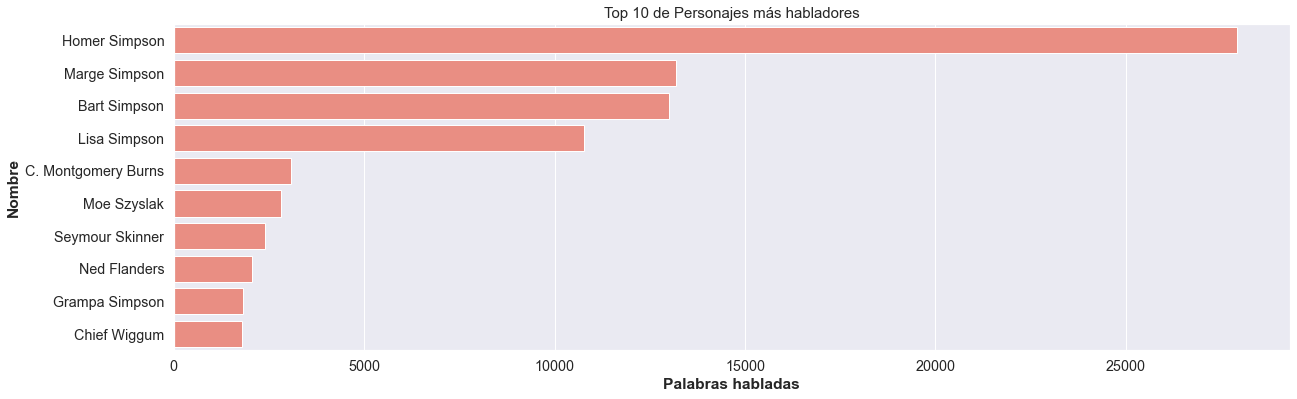

In [8]:
### Top personajes con más palabras habladas
topCharacters = df.groupby("name",as_index=False).count().sort_values("spoken_words", ascending=False).reset_index(drop=True)
topCharactersNames = topCharacters.head(20).name.tolist()
display(topCharacters.head(10))

sns.set(style="white")

sns.set(font_scale=1.3)  
sns.barplot(x='spoken_words', y='name', data=topCharacters.head(10), color = "salmon")         

plt.title("Top 10 de Personajes más habladores", size=15)
plt.xlabel('Palabras habladas', fontweight='bold', horizontalalignment='center')
plt.ylabel('Nombre', fontweight='bold', horizontalalignment='center')
fig=plt.gcf()
fig.set_size_inches(20,6)
plt.show()

<hr>

### Preprocesamiento del texto
* Eliminar los caracteres no-alfabéticos
* Elimiar stop words
* Aplicar técnica de lemitization

In [9]:
### Eliminar los caracteres no-alfabéticos:
df.spoken_words = [re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words']]
df.spoken_words= [re.sub("[/']", '', str(row)).lower() for row in df.spoken_words]

In [10]:
import nltk
nltk.download('omw-1.4')
    
import functools
import operator
from nltk.corpus import stopwords

# Quitamos las "stop words" del inglés
stopwords = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def processSentence(sentence):
    ww = sentence.split()
    ww = [x for x in ww if x not in stopwords]
    ww = [x for x in ww if x !=""]
    ww = [lemmatizer.lemmatize(x) for x in ww]
    
    if len(ww)>2:
        return " ".join(ww) 
    else:
        return np.nan

cleaned = [processSentence(x) for x in df.spoken_words.tolist()]

dfCleaned = df.copy()
dfCleaned.spoken_words = cleaned
dfCleaned = dfCleaned.dropna()
dfCleaned = dfCleaned[~dfCleaned.spoken_words.duplicated()]
dfCleaned.columns = ["Name", "Sentence"]

wordsDf = pd.DataFrame(cleaned, columns=["sentence"]).dropna().drop_duplicates()
print("Conteo de palabras después del procesamiento: "+ str(len(wordsDf)))

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\natam\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Conteo de palabras después del procesamiento: 97423


### 2. Ranking de las palabras más Comunes

,Word,Count
0,im,8951
1,oh,7216
2,well,6671
3,dont,6431
4,like,5981
5,get,5143
6,one,4870
7,youre,4752
8,know,4626
9,thats,4063


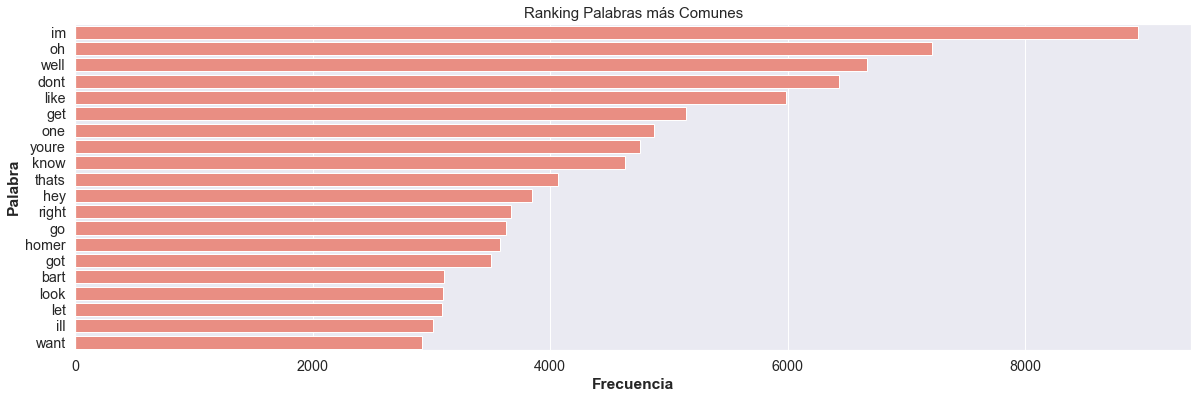

In [11]:
words = [x.split() for x in wordsDf.sentence.tolist()]
words = functools.reduce(operator.iconcat, words, [])
wordCountsDF = pd.DataFrame(pd.Series(words).value_counts(), columns=["Count"])
wordCountsDF["Word"] = wordCountsDF.index
wordCountsDF = wordCountsDF[["Word", "Count"]].reset_index(drop=True)
display(wordCountsDF.head(10))

sns.set(style="whitegrid")

sns.set(font_scale=1.3)  
sns.barplot(x='Count', y='Word', data=wordCountsDF.head(20), color="salmon")            
plt.title("Ranking Palabras más Comunes", size=15)
plt.xlabel('Frecuencia', fontweight='bold', horizontalalignment='center')
plt.ylabel('Palabra', fontweight='bold', horizontalalignment='center')
fig=plt.gcf()
fig.set_size_inches(20,6)
plt.show()

### 3. Word cloud

Creación de un wordplot con las palabras más comunes habladas en la serie.

La palabra en la posición 14 es "homer" y en la posición 17 es "bart".

La palabra más común (im) está en mayor tamaño, y el tamaño se reduce con las palabras menos frecuentes.

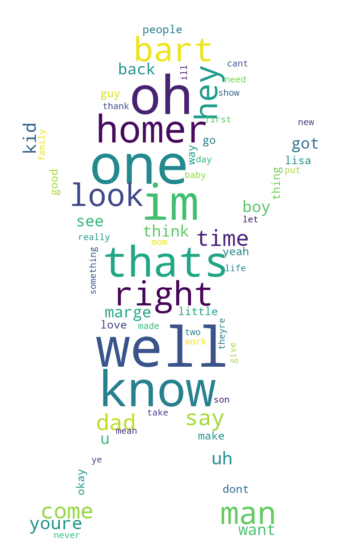

In [12]:

from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib.pyplot as plt
stopwords = list(set(STOPWORDS))


def show_wordcloud(data, photo_path):
    mask = np.array(Image.open(photo_path))
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=50, 
        scale=5,
        random_state=1, # chosen at random by flipping a coin; it was heads
        mask=mask,
        mode="RGBA",
        # contour_color='#023075',contour_width=3,colormap='rainbow'
    ).generate(str(data))

    fig = plt.figure(1, figsize=(16, 10))
    plt.axis('off')

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()

photo_path = "./data/bart.png"
show_wordcloud(" ".join(words), photo_path)

### 4. Gráfico de Dispersión

Aquí miramos a palabras comunes y vemos su distribución a lo largo de los episodios.

La lista de palabras es ["homer", "simpson", "marge", "bart", "lisa"]

Se aprecia que todas estas palabras se distribuyen de forma uniforme a lo largo de todos los diálogos (de los 600 episodios)

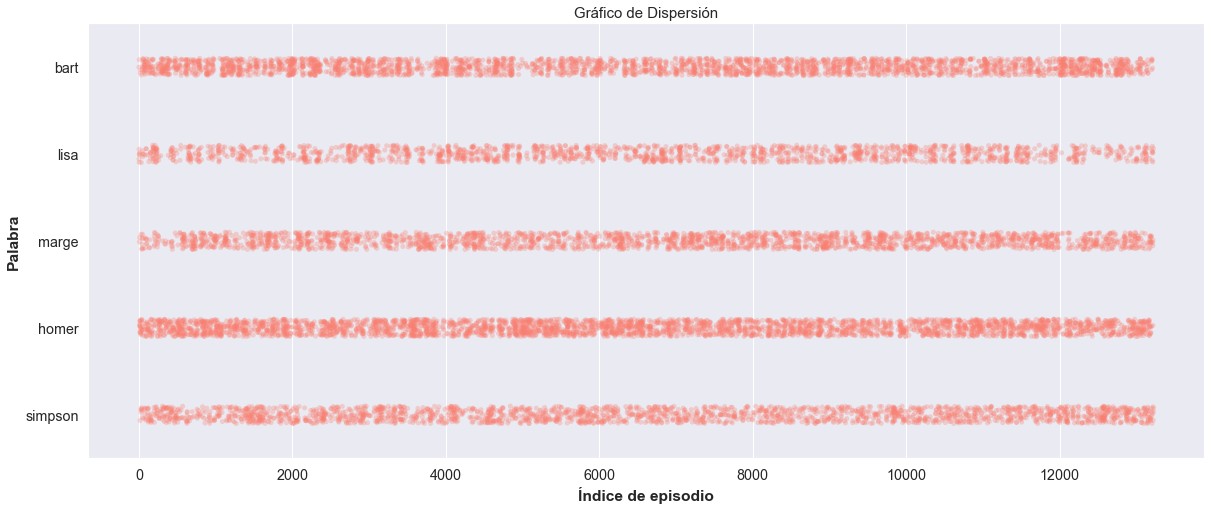

In [13]:
tt= wordCountsDF.Word.tolist()

tt = ["homer", "simpson", "marge", "bart", "lisa"]

wordsTemp = [x for x in words if x in tt]
tempdf = pd.DataFrame(wordsTemp, columns=["Word"])
tempdf["Ind"] = tempdf.index

sns.set(style="whitegrid")

wordsTemp = [x for x in words if x in tt]
sns.set(font_scale=1.3)  
sns.stripplot(x="Ind", y="Word", data=tempdf, color="salmon", alpha=0.3)            
plt.title("Gráfico de Dispersión", size=15)
plt.xlabel('Índice de episodio', fontweight='bold', horizontalalignment='center')
plt.ylabel('Palabra', fontweight='bold', horizontalalignment='center')
fig=plt.gcf()
fig.set_size_inches(20,8)
plt.show()

### 5. Ranking de las Palabras Más Importantes por Personaje

Se usa la técnica de TF-IDF (es una medida numérica que expresa cuán relevante es una palabra para un documento en una colección)

Aplicamos la técnica en **Bart Simpson**

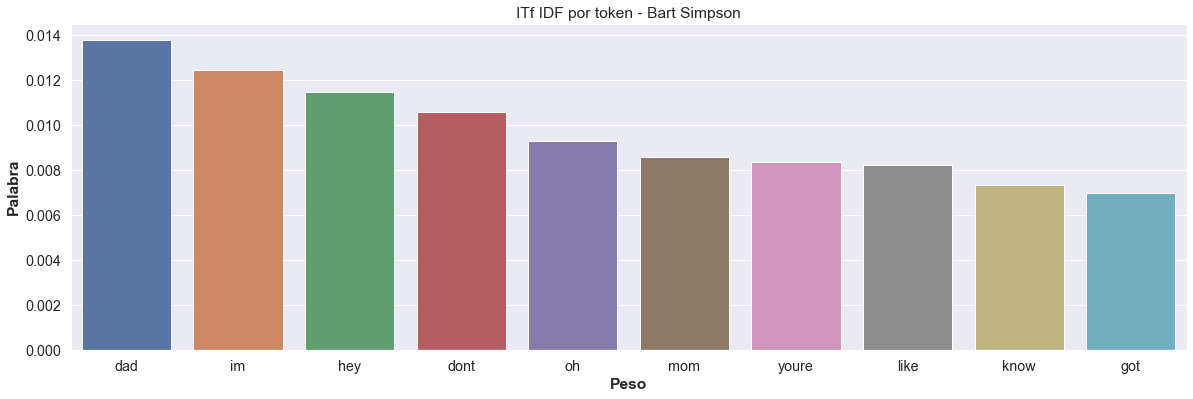

In [14]:
# Usaremos CountVectorizer para convertir una colección de documentos de texto a una matriz de conteo de tokens. 
# TfidfTransformers hace la transfromación de una matriz a un TF normalizado o representación TF-IDF.

# Usamos 4 parámetros en el método CountVectorizer. Primero, stop_words elimina las stop words (aquellas palabras repetidas que no contienen información relevante). 
# En Scikit-learn, la lista de palabras stop words en inglés está incluida. 
# min_df es el límite mínimo para ignorar palabras con una frecuencia menor a min_df. 
# max_df es el límite superior, si la frequencia de una palabra en un documento es mayor a ese límite se ignora. 
# ngram_range(x,y) es el último parámetro. Define los límites de valores de n para los n-grams, que van del mñinimo (x) al máximo (y). 
# fit_transform devuelve la versión transformada de las frases.

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

txt1 = [x for x in cleaned if str(x)!="nan"]
txt1 = dfCleaned[dfCleaned.Name=="Bart Simpson"].Sentence.tolist()

cvec = CountVectorizer(stop_words="english", analyzer='word', ngram_range=(1, 2), max_df=1.0, min_df=1)
sf = cvec.fit_transform(txt1)
    
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(sf)
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df = weights_df.sort_values("weight", ascending=False).reset_index(drop=False)

sns.barplot(x='term', y='weight', data=weights_df.head(10))            
plt.title("ITf IDF por token - Bart Simpson")
plt.xlabel('Peso', fontweight='bold', horizontalalignment='center')
plt.ylabel('Palabra', fontweight='bold', horizontalalignment='center')
fig=plt.gcf()
fig.set_size_inches(20, 6)
plt.show()

Se observa que la palabra más relevante para Bart es 'dad'.

Probamos esta técnica en otro personaje de la serie. 

Se analizarán las palabras más relevantes para el vecino de los Simpsons, Ned Flanders.

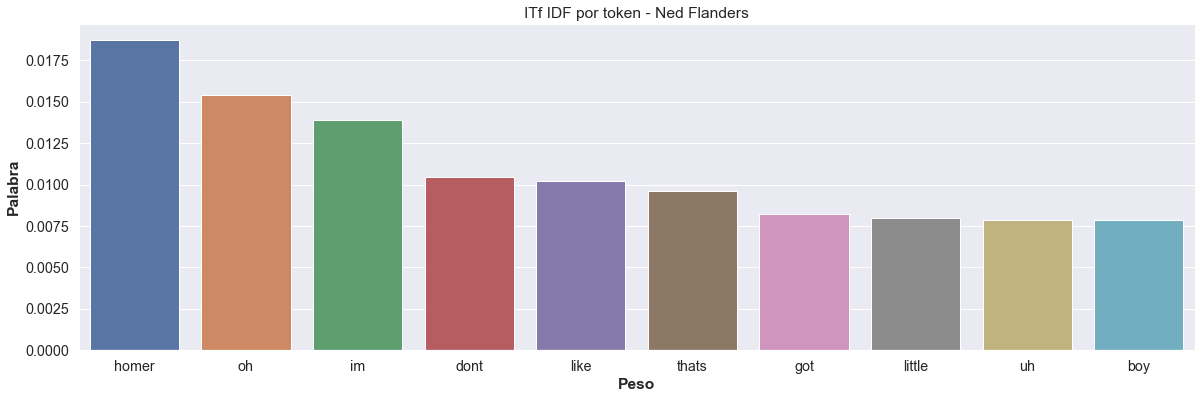

In [15]:
txt1 = [x for x in cleaned if str(x)!="nan"]
txt1 = dfCleaned[dfCleaned.Name=="Ned Flanders"].Sentence.tolist()

cvec = CountVectorizer(stop_words="english", analyzer='word', ngram_range=(1, 2), max_df=1.0, min_df=1)
sf = cvec.fit_transform(txt1)
    
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(sf)
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df = weights_df.sort_values("weight", ascending=False).reset_index(drop=False)

sns.barplot(x='term', y='weight', data=weights_df.head(10))            
plt.title("ITf IDF por token - Ned Flanders")
plt.xlabel('Peso', fontweight='bold', horizontalalignment='center')
plt.ylabel('Palabra', fontweight='bold', horizontalalignment='center')
fig=plt.gcf()
fig.set_size_inches(20, 6)
plt.show()

Para Ned Flanders la palabra más relevante es "homer", esta palabra hace referencia a la misma persona que en el caso de Bart Simpson. 

En los dos casos, la palabra más relevante hace referencia a Homer Simpson.

Esto puede resultar interesante, y se podría analizar como cada personaje llama a la misma persona. Ejemplo: Dad, Homer, Mr. Simpson...

<hr>

## Relaciones entre palabras

Se han explorado las palabras que son más importantes para un personaje. Ahora, se explorarán las relaciones entre palabras.

Se usará la técnica de NLP de n-Grams!


Convertimos los datos a nGrams de 2 palabras
* N-grams (sets of consecutive words)
* N=2

### 6. Bi-grams

In [16]:
from nltk.util import ngrams
import collections
import itertools

ngrams = list([nltk.ngrams(words, 2)])

# Lista flatten list de bigrams
bigrams = list(itertools.chain(*ngrams))

# Crear un conteo de palabras en los bigrams
bigram_counts = collections.Counter(bigrams)
bigram_df = pd.DataFrame(bigram_counts.most_common(30), columns=['bigram', 'count'])

display(bigram_df.head(10))

,bigram,count
0,"(im, gonna)",825
1,"(dont, know)",743
2,"(im, sorry)",599
3,"(ive, got)",568
4,"(look, like)",564
5,"(dont, worry)",517
6,"(mr, burn)",478
7,"(homer, simpson)",446
8,"(dont, want)",413
9,"(let, go)",401


De los bigrams, se observan combinaciones entre palabras habituales. Por ejemplo, el tercer bigram más común es "im, sorry", una expresión común.

El bigram más común entre los episodios de "The Simpsons" es "im, gonna"

In [17]:
# !pip install networkx

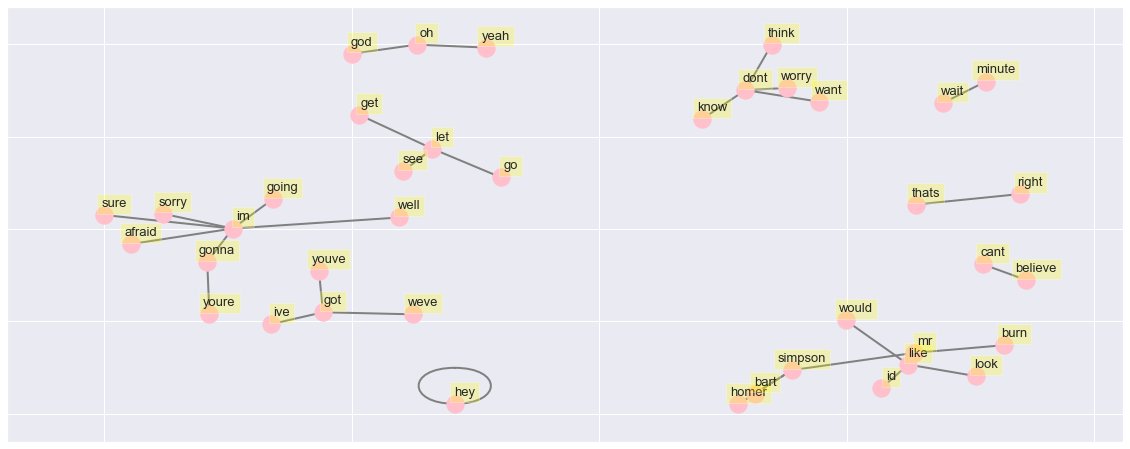

In [18]:
### Visualizar el network de Bigrams

import networkx as nx

def visualiseBigrams(bigram_df, K):
    d = bigram_df.set_index('bigram').T.to_dict('records')

    # Crear el network plot 
    G = nx.Graph()

    # Crear las conexiones entre nodos
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v * 10))

    # G.add_node("china", weight=100)
    fig, ax = plt.subplots(figsize=(20, 8))
    
    # k : float (default=None)
    # Distancia óptima entre nodos. 
    # Si es 'None' la distancia es 1/sqrt(n) donde n es el número de nodos. Al aumentar este valor la distancia entre nodos aumenta.
    pos = nx.spring_layout(G, k=K)

    # Representar los networks gráficamente
    nx.draw_networkx(G, pos,
                     font_size=13,
                     width=2,
                     edge_color='grey',
                     node_color='pink',
                     with_labels = False,
                     ax=ax)

    # Crear las etiquetas de offset
    for key, value in pos.items():
        x, y = value[0]+.02, value[1]+.045
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='yellow', alpha=0.25),
                horizontalalignment='center', fontsize=13)
    plt.grid(True)
    plt.show()
    
visualiseBigrams(bigram_df=bigram_df,  K=5)

La gráfica de los bigrams de arriba muestra palabras que deberían seguir a otras.

Se aprecia que la palabra "im" debe ser precedida por palabras como:
 * sure
 * afraid
 * gonna
 * sorry
 * well
 * going
 
Analizando los distintos bigrams y las palabras que preceden la palabra base, sí parece tener sentido.

### Crear el gráfico de "network" para una palabra en específico

Elegimos la palabra "simpson", y sacamos las 20 palabras más comunes que siguen a "simpson"

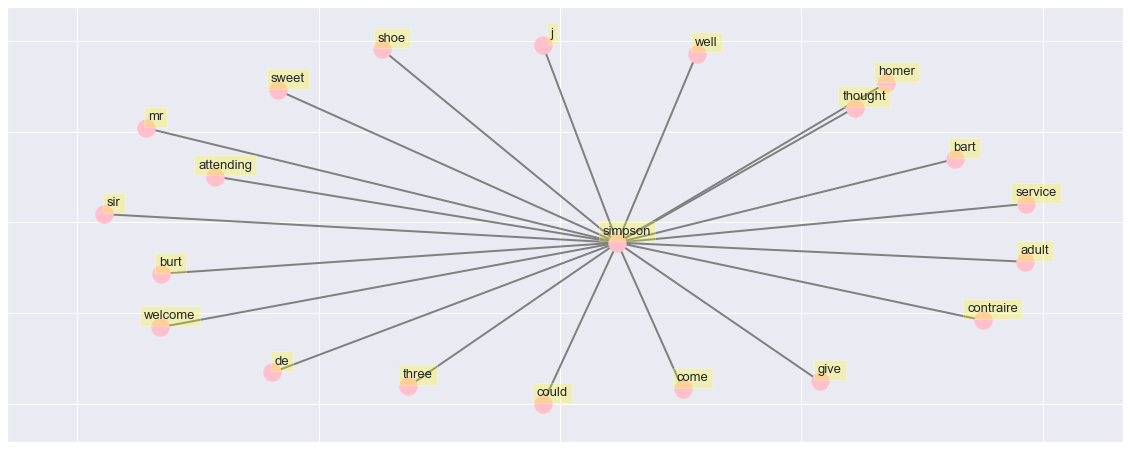

In [19]:
### Gráfico de una palabra en específica

wordGToGraph = "simpson"
bigram_df = pd.DataFrame(bigram_counts.most_common(20), columns=['bigram', 'count'])

### filter nframs list
bigram_counts_filter = []
for k in bigram_counts:
    #print(k)
    if wordGToGraph in k:
        bigram_counts_filter.append(k)
        
bigram_counts_filter = collections.Counter(bigram_counts_filter)
bigram_df_filter = pd.DataFrame(bigram_counts_filter.most_common(20), columns=['bigram', 'count'])
visualiseBigrams(bigram_df=bigram_df_filter,  K=5)

### N-grams con n = 3

En este caso, es más difícil/útil sacar n-grams con 3 palabras relacionadas.

Como comentario, aparece 81 veces las 3 palabras juntas: ("kwik","e", "mart"), que hace referencia al "badulake" que es el supermercado donde suele acudir la familia Simpson y 60 veces aparece: ("santa","little", "helper"), que se refiere al perro de la familia: "pequeño ayudante de Santa Claus".

In [20]:

ngrams = list([nltk.ngrams(words, 3)])

# Lista flatten list de bigrams
bigrams = list(itertools.chain(*ngrams))

# Crear un conteo de palabras en los bigrams
bigram_counts = collections.Counter(bigrams)
bigram_df = pd.DataFrame(bigram_counts.most_common(30), columns=['bigram', 'count'])

display(bigram_df.head(10))

,bigram,count
0,"(la, la, la)",183
1,"(ha, ha, ha)",94
2,"(whoa, whoa, whoa)",87
3,"(kwik, e, mart)",81
4,"(heh, heh, heh)",78
5,"(ive, never, seen)",72
6,"(blah, blah, blah)",70
7,"(hey, hey, hey)",70
8,"(ow, ow, ow)",61
9,"(santa, little, helper)",60


<hr>

### 7. Sentiment analysis por cada personaje

Para el séptimo apartado del proyecto, se va a analizar el "sentimiento" de los personajes principales. Esta práctica es muy común y separará a los personajes más alegres y menos, dependiendo de su manera de hablar y las palabras usadas en los diálogos.

Para hacer esta clasificación, se recurre a la librería TextBlob que devuelve la ppolaridad y la subjetividad de una frase. A cada línea de diálogo se le asigna una puntuación de 1 (sentimiento positivo) a -1 (sentimiento negativo) y sacando el valor medio de las líneas agrupando por personaje.

In [21]:
from textblob import TextBlob
### Calcular sentimiento para todos los datos
dfCleaned["Sentiment"] = [TextBlob(x).sentiment.polarity for x in dfCleaned.Sentence]

In [22]:
## Seleccionamos un subset, son los 70 primeros personajes que aparecen
topCharactersNames = topCharacters.head(70).name.tolist()
dfCleanedTopCharacters = dfCleaned[dfCleaned.Name.isin(topCharactersNames)]

##### Sentimientos más negativos (Top 5):

In [23]:
### top sentimientos menos positivos: (head)
dfCleanedTopCharacters.sort_values("Sentiment").head().reset_index(drop=True)

,Name,Sentence,Sentiment
0,Homer Simpson,one vicious baby bird,-1.0
1,Homer Simpson,thats boring youre boring everybody quit boring everyone,-1.0
2,C. Montgomery Burns,yes there nothing pathetic self delusion eh,-1.0
3,Groundskeeper Willie,youre worst get poisonin squirrel,-1.0
4,Sideshow Bob,dont wish brag he evil eighth grade level,-1.0


##### Sentimientos más positivos (Top 5):

In [24]:
### top sentimientos más positivos: (tail)
dfCleanedTopCharacters.sort_values("Sentiment").tail().reset_index(drop=True)

,Name,Sentence,Sentiment
0,Bart Simpson,wouldve thought visit itchy scratchy land would turn best vacation ever,1.0
1,Comic Book Guy,best death ever,1.0
2,Homer Simpson,lisa think im greatest might even put work bart maggie go superdad ass,1.0
3,Bart Simpson,j product need e excellent value r retailer dream k,1.0
4,Bart Simpson,krusty youre getting best review career,1.0


In [25]:
### Sentimiento por personaje
sentimentByName = dfCleanedTopCharacters[dfCleanedTopCharacters.Sentiment.abs()>=0.05].groupby("Name", as_index=False).mean()
sentimentByName = sentimentByName.sort_values("Sentiment", ascending=False).reset_index(drop=True)

### Representación de los Sentimientos de 20 de los peronsajes con mejor y peor puntuación de Sentimiento

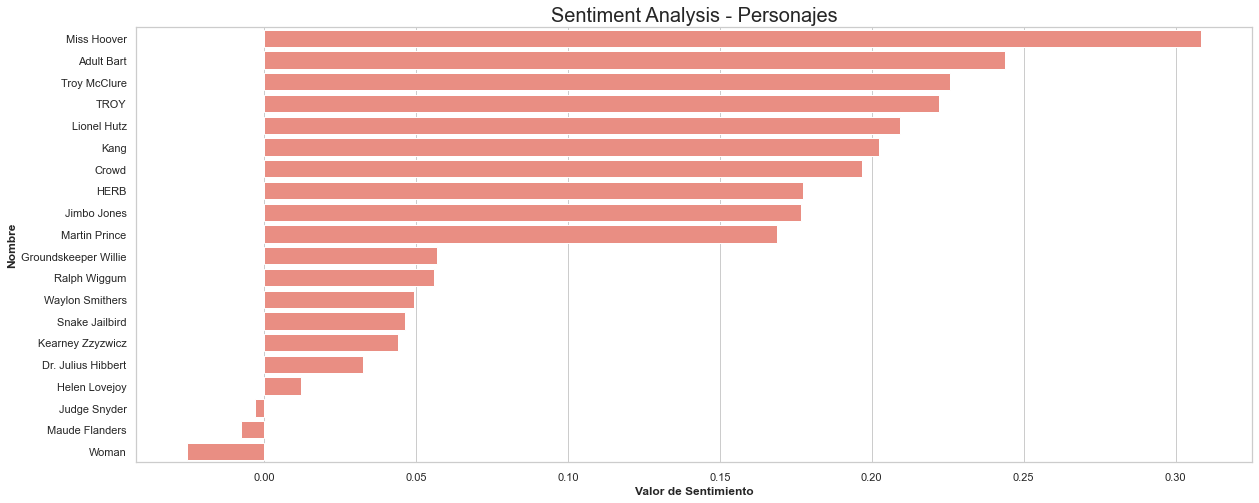

In [26]:
sns.set(style="whitegrid")

tempSentiment = sentimentByName.head(10)
tempSentiment = tempSentiment.append(sentimentByName.tail(10)).reset_index(drop=True)

sns.barplot(x='Sentiment', y='Name', data=tempSentiment, color="salmon")            
plt.title("Sentiment Analysis - Personajes", size=20)
plt.xlabel('Valor de Sentimiento', fontweight='bold', horizontalalignment='center')
plt.ylabel('Nombre', fontweight='bold', horizontalalignment='center')
fig=plt.gcf()
fig.set_size_inches(20,8)
plt.show()

La persona con el sentimiento más positivo es "Miss Hoover", seguido de "Adult Bart"

Las personas más negativas en sentimiento son "Maude Flanders" y "Woman"

### Representación de los Sentimientos de los Protagonistas

In [27]:
## Comparar los sentimientos de los protagonistas:
filtro = sentimentByName[sentimentByName['Name'].str.contains("Simpson", case=False)]
filtro = filtro.sort_values("Sentiment", ascending=False).reset_index(drop=True)
filtro

,Name,Sentiment
0,Marge Simpson,0.138527
1,Homer Simpson,0.114159
2,Lisa Simpson,0.109406
3,Mona Simpson,0.105774
4,Bart Simpson,0.090508
5,Grampa Simpson,0.084132


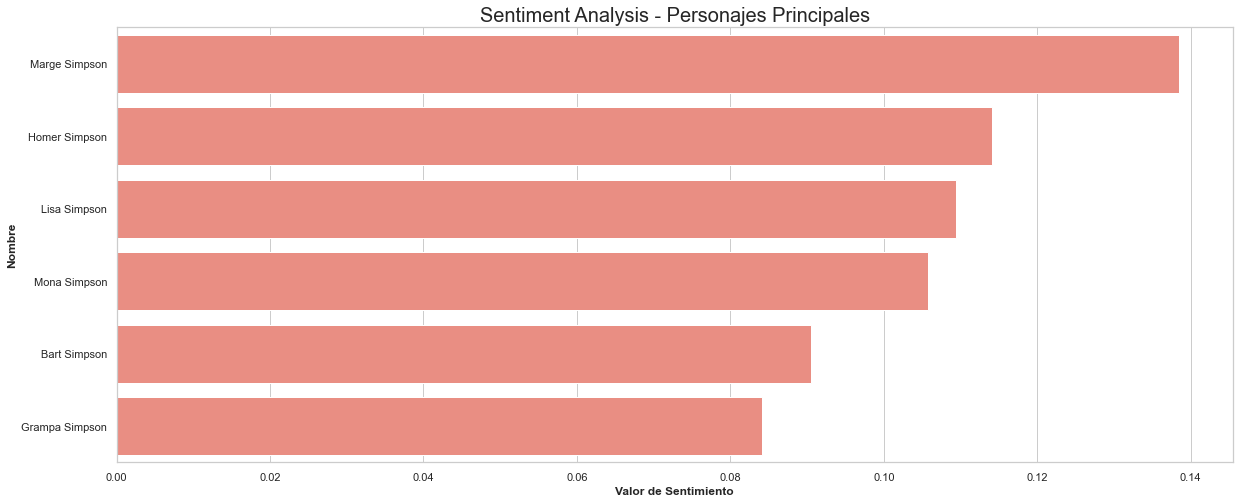

In [28]:
sns.set(style="whitegrid")

sns.barplot(x='Sentiment', y='Name', data=filtro, color="salmon")            
plt.title("Sentiment Analysis - Personajes Principales", size=20)
plt.xlabel('Valor de Sentimiento', fontweight='bold', horizontalalignment='center')
plt.ylabel('Nombre', fontweight='bold', horizontalalignment='center')
fig=plt.gcf()
fig.set_size_inches(20,8)
plt.show()

De los protagonistas de la serie observamos que

* Marge Simpson tiene el sentimiento más positivo, aunque es bajo (0.139).
* El abuelo de los Simpson es el protagonista con la menor puntuación (menos positivo).
* Los protagonistas tienen todos un sentimiento positivio pero prácticamente neutral.

<hr>

### 8. Rolling Sentiment - Sentimiento a lo largo de los episodios

In [29]:
## Comparamos la puntuación del Sentimiento a lo largo de los episodios
def rollingSentiment(data, character, window, k):
    if character!="":
        temp = data[data.Name==character].reset_index(drop=True)
    else:
        temp = data.copy()
    temp = temp[temp.Sentiment.abs()>=k].reset_index(drop=True)
    movingS = temp.rolling(window).mean().dropna()
    movingS["Time"] = movingS.index
    
    sns.set(style="whitegrid")
    sns.set(font_scale=1.3)  
    sns.lineplot(x="Time", y='Sentiment', data=movingS, color="b")            
    plt.title("Sentimiento para " + character, size=20)
    plt.xlabel('Tiempo', fontweight='bold', horizontalalignment='center')
    plt.ylabel('Valor de Sentimiento', fontweight='bold', horizontalalignment='center')
    plt.ylim(-0.1,0.3)
    # plt.xlim(0,400)
    fig=plt.gcf()
    fig.set_size_inches(20, 6)
    plt.show()
    return movingS


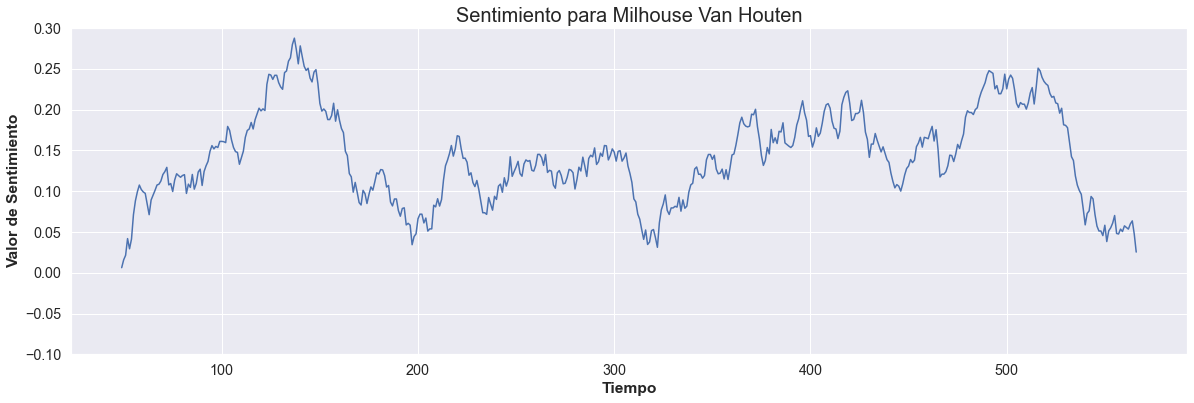

In [30]:
rolData = rollingSentiment(data=dfCleaned, character="Milhouse Van Houten", window=50, k=0.05)

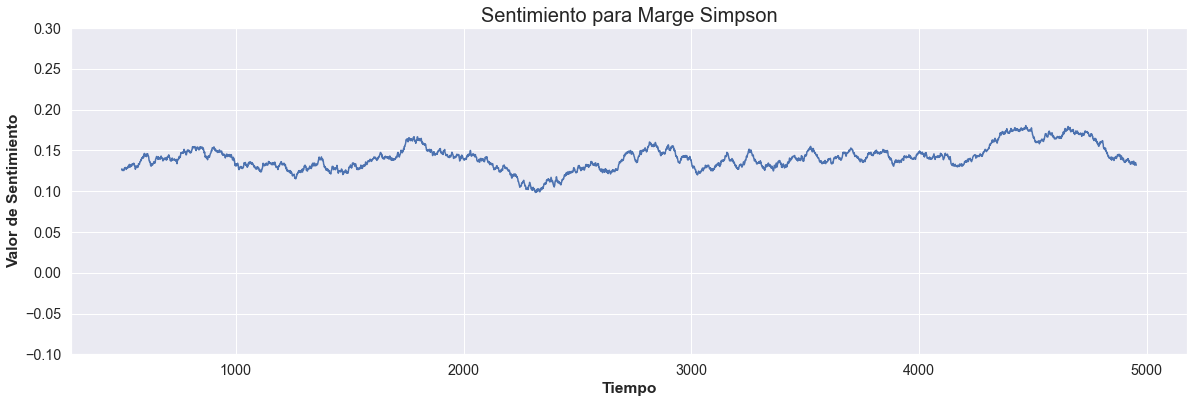

In [31]:
rolData = rollingSentiment(data=dfCleaned, character="Marge Simpson", window=500, k=0.05)

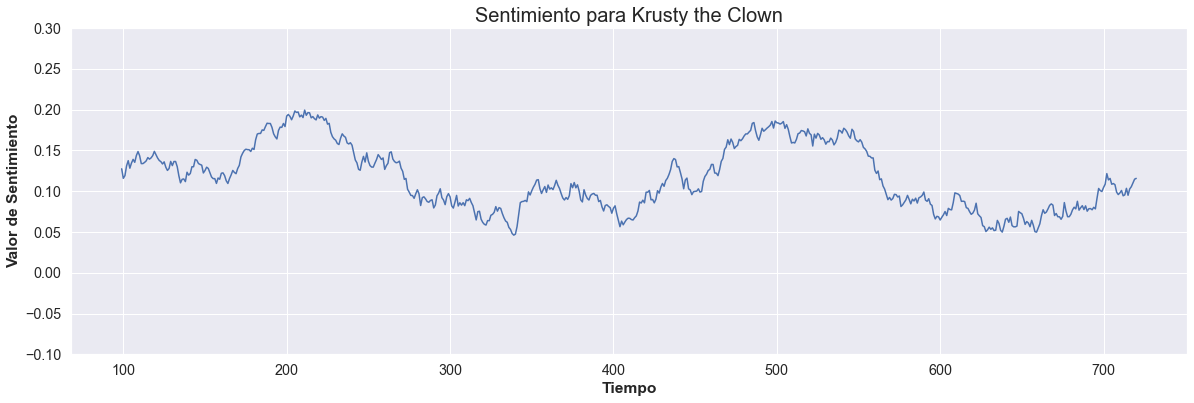

In [32]:
rolData = rollingSentiment(data=dfCleaned, character="Krusty the Clown", window=100, k=0.05)

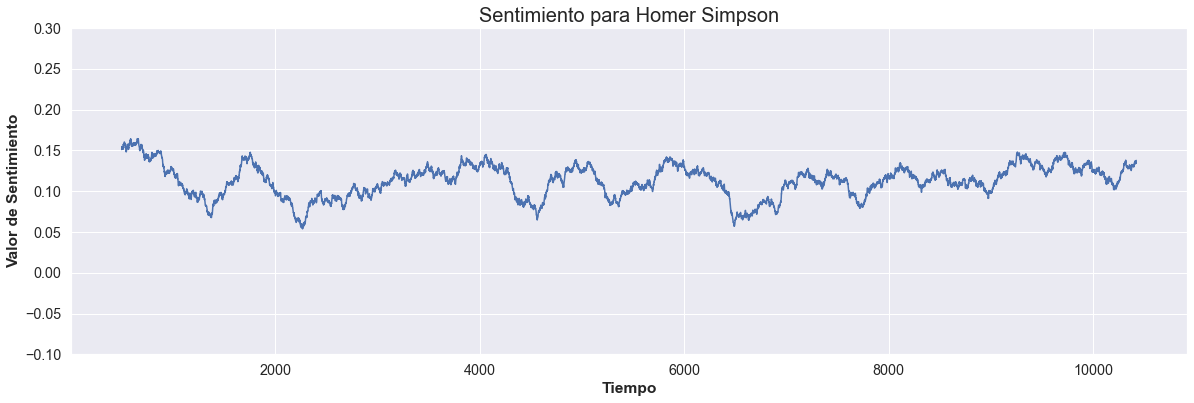

In [33]:
rolData = rollingSentiment(data=dfCleaned, character="Homer Simpson", window=500, k=0.05)

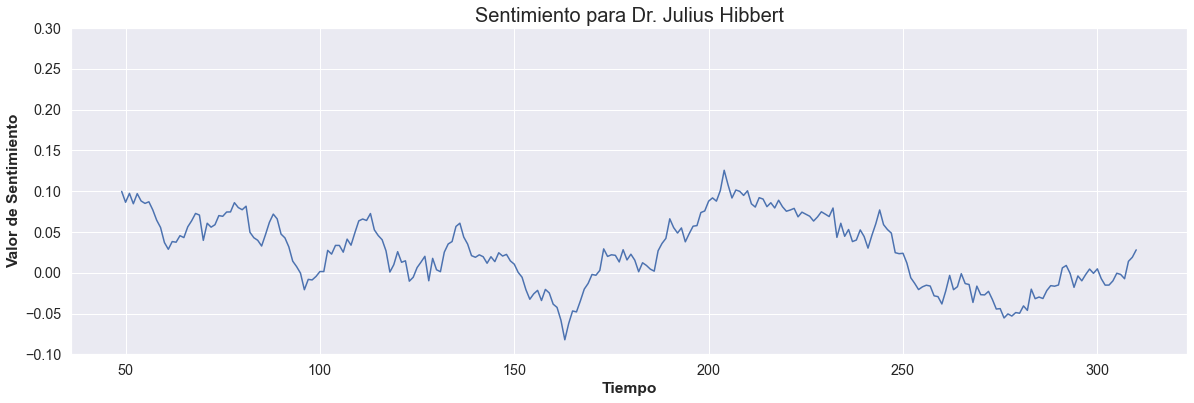

In [34]:
rolData = rollingSentiment(data=dfCleaned, character="Dr. Julius Hibbert", window=50, k=0.05)

Al representarlo con los mismos límites en el eje y, se puede apreciar que cada personaje evoluciona de una manera diferente siendo el Dr Hibbert el que parece tener un sentimiento más negativo a lo largo de los episodios alcanzando el pico mínimo en el intervalo [150, 180]

<hr>

### 9. Word Embedding - Word2Vec

### Training the model
#### Implementación del modelo de Gensim Word2Vec :

In [35]:
import multiprocessing
from gensim.models import Word2Vec

Utilizando la función de procesamiento definida al principio se realiza el preprocesamiento:

In [36]:
cleaned2 = [processSentence(x) for x in df.spoken_words.tolist()]
words22 = [x for x in cleaned2 if str(x)!="nan"]

In [37]:
cores = multiprocessing.cpu_count() # Cuenta los cores del ordenador
words33 = [x.split() for x in words22]

In [38]:
w2v_model = Word2Vec(min_count=20,
                     window=5,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     sg = 1)

w2v_model.build_vocab(words33, progress_per=10000)

vocab_size = len(w2v_model.wv.key_to_index.keys())

In [39]:
st = datetime.now()

w2v_model.train(words33, total_examples=w2v_model.corpus_count, epochs=50, report_delay=1)

print('Tiempo de entrenamiento: ' +  str(datetime.now()-st))

Tiempo de entrenamiento: 0:00:46.466350


In [40]:
w2v_model.init_sims(replace=True) # para normalizar los vectores de word2vec 

### Explorar el modelo

#### Palabras más similares a otras:

Aquí, pedimos a nuestro modelo que encuentre las palabras más similares a los protagnistas de "The Simpsons"

##### Empezamos con Homer

In [41]:
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.6414967775344849),
 ('now', 0.6091830730438232),
 ('simpson', 0.6017093658447266),
 ('well', 0.5858743786811829),
 ('bart', 0.5601828098297119),
 ('know', 0.5584063529968262),
 ('oh', 0.5552235841751099),
 ('im', 0.5428253412246704),
 ('youre', 0.533694863319397),
 ('mr', 0.5323084592819214)]

La palabra más similar a homer es "simpson"

##### Seguimos con Simpson:

In [42]:
w2v_model.wv.most_similar(positive=["simpson"])

[('homer', 0.6017093658447266),
 ('bart', 0.5386074781417847),
 ('mr', 0.52976393699646),
 ('now', 0.527967631816864),
 ('man', 0.4635397493839264),
 ('lisa', 0.45160162448883057),
 ('one', 0.4511943459510803),
 ('u', 0.45113837718963623),
 ('marge', 0.44732892513275146),
 ('thats', 0.44347167015075684)]

##### Marge:

In [43]:
w2v_model.wv.most_similar(positive=["marge"])

[('homer', 0.6414967775344849),
 ('well', 0.5949987173080444),
 ('now', 0.5905675292015076),
 ('right', 0.5602823495864868),
 ('bart', 0.5387349128723145),
 ('oh', 0.5339192152023315),
 ('know', 0.532975435256958),
 ('one', 0.5283428430557251),
 ('im', 0.5244868993759155),
 ('dont', 0.52067631483078)]

##### Bart:

In [44]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.6710975170135498),
 ('now', 0.6209166049957275),
 ('boy', 0.5931216478347778),
 ('im', 0.560770571231842),
 ('homer', 0.5601828098297119),
 ('kid', 0.5533363819122314),
 ('know', 0.5532933473587036),
 ('dad', 0.552986204624176),
 ('well', 0.540912926197052),
 ('marge', 0.5387349128723145)]

#### Similitudes:

Aquí, comparamos dos palabras para ver como son de similares entre ellas

Primero, comparamos a "maggie" con "baby"

In [45]:
w2v_model.wv.similarity('maggie', 'baby')

0.35275817

Ahora a "homer" con "dad"

In [46]:
w2v_model.wv.similarity('homer', 'dad')

0.48659158

#### Diferencia de analogía:

¿Qué palabra es para "woman" como "homer" es a "man"?

In [47]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["man"], topn=3)

[('marge', 0.3952931761741638),
 ('know', 0.3414468765258789),
 ('now', 0.3326995372772217)]

#### Relaciones entre los nombres de los personajes

Creamos un modelo de PCA en 2-dimensiones de los vectores de palabras usandola clase de PCA de scikit-learn.

Usamos los primeros 20 personajes.

In [48]:
### Viz characters
characters = topCharacters.head(20).name.tolist()
characters = [re.sub("[^A-Za-z.']+", ' ', str(row)).lower() for row in characters]
characters = [re.sub("[/']", '', str(row)) for row in characters]
characters = sum([x.split() for x in characters], [])
characters = np.unique([x for x in characters if len(x)>2 and "." not in x ])
characters = [x for x in characters if x in w2v_model.wv.key_to_index.keys()]

In [49]:
X = w2v_model.wv[characters]

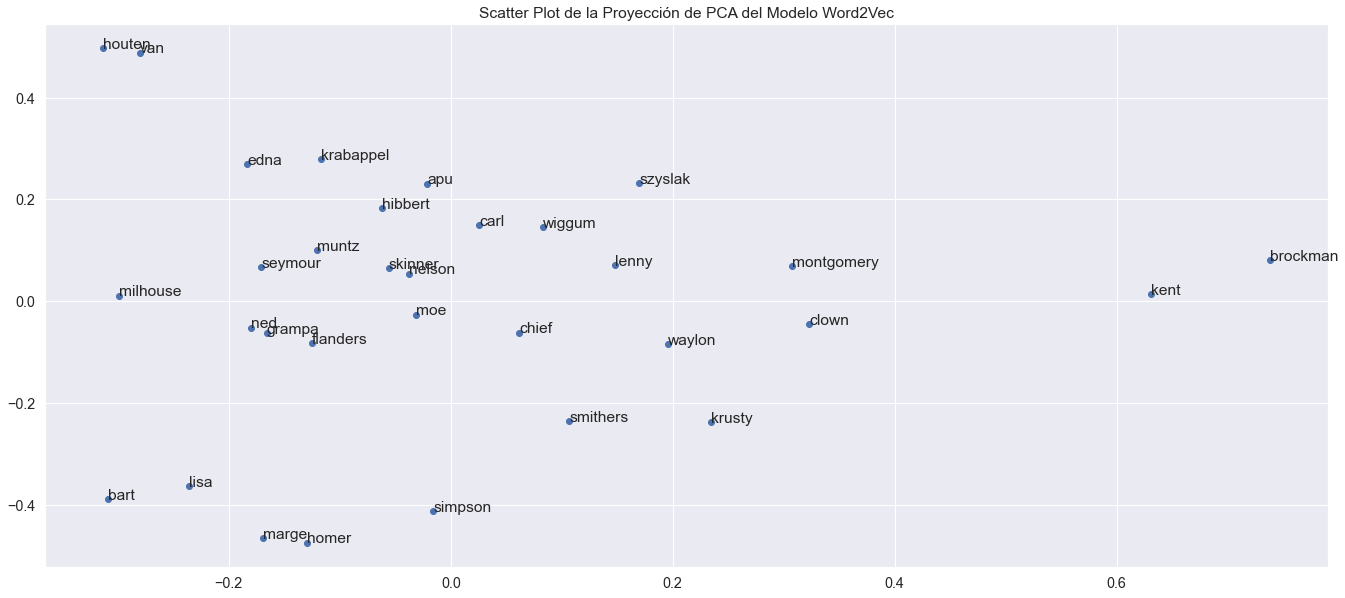

In [50]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2)

result = pca.fit_transform(X)

# crear un plot de scatter de la projección
fig = plt.figure(figsize=(23,10))
ax = fig.add_subplot(111)
ax.scatter(result[:, 0], result[:, 1])
ax.set_title("Scatter Plot de la Proyección de PCA del Modelo Word2Vec")
for i, word in enumerate(characters):
    ax.annotate(word, xy=(result[i, 0]+0.0001, result[i, 1]))
plt.show()

Se podría comentar que en el lado derecho del gráfico aparecen los protagonistas de la famila Simpson (una clara agrupación)

#### 10 Palabras con Mayor similitud words vs. 8 Palabras Aleatorias:

In [51]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    
    sns.set_style("darkgrid")

    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE

    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(15, 7)
    
    # Basic plot
    sns.set(font_scale=1.3)  
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.title('Visualización de t-SNE para {}'.format(word.title()), size=20)
    

El objetivo es representar el vector con altas dimensiones a un gráfico de 2 dimensiones.

Para ello se usará la implementación de t-SNE de scikit-learn.

La visualización se compone de:
* la palabra de la query (en **rojo**)
* las palabras más similares de la palabra de la query (en **azul**)
* palabras aleatorias (en **verde**)


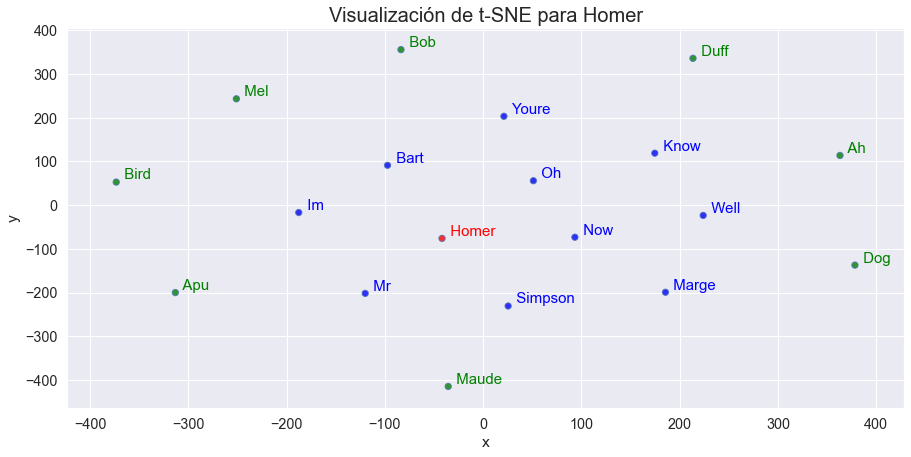

In [52]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

Se observa como las palabras más similares a "homer" aparecen más cerca (azules) que las aleatorias (verde) - esto era lo esperado.

<hr>


Con esto se acaba nuestro análisis NLP de los diálogos de la serie de The Simpsons!